In [1]:
from __future__ import print_function, division, absolute_import

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astroquery
from astropy.io import fits
from astropy.table import Table
from scipy import stats
import sklearn
from matplotlib.pyplot import figure

%matplotlib notebook

# Building Histograms with Bayesian Priors
## An Introduction to Bayesian Blocks
========

#### Version 0.1

***
By LM Walkowicz 2019 June 14

*This notebook makes heavy use of Bayesian block implementations by Jeff Scargle, Jake VanderPlas, Jan Florjanczyk, and the Astropy team.*

## Problem 1) Histograms Lie!

One of the most common and useful tools for data visualization can be incredibly misleading. Let's revisit how.

![ChessUrl](https://media.giphy.com/media/EouEzI5bBR8uk/giphy.gif "chess")




**Problem 1a**

First, let's make some histograms! Below, I provide some data; please make a histogram of it.

In [5]:
# execute this cell
np.random.seed(0)
x = np.concatenate([stats.cauchy(-5, 1.8).rvs(500),
                    stats.cauchy(-4, 0.8).rvs(2000),
                    stats.cauchy(-1, 0.3).rvs(500),
                    stats.cauchy(2, 0.8).rvs(1000),
                    stats.cauchy(4, 1.5).rvs(500)])

# truncate values to a reasonable range
x = x[(x > -15) & (x < 15)]

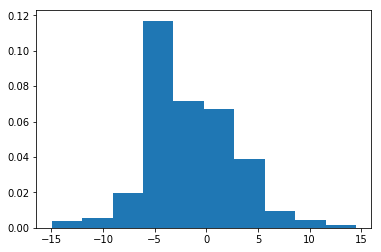

In [6]:
# plt.hist( # complete
H = plt.hist(x, density=True)

**Hey, nice histogram!** 

But how do we know we have visualized all the relevant structure in our data? 

*Play around with the binning and consider: 
What features do you see in this data? Which of these features are important?*

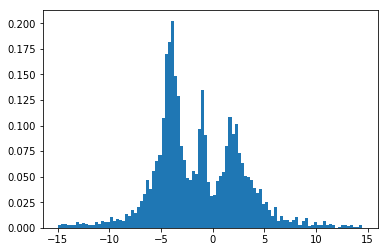

In [7]:
# plt.hist # complete
H = plt.hist(x, bins=100, density=True)


**Problem 1b**

What are some issues with histograms? 

*Take a few min to discuss this with your partner*

**Solution 1b**

*write your solution here*

**A Partial List of Histogram Concerns**

- no really rigorous ways to choose important parameters (e.g. number/width of bins)
- changes to user choices (number of bins, bin centering, etc) can significantly change output
- the resulting distribution may not provide a good representation of the underlying probability density function
- they introduce discontinuites that may not exist in data
- not great for visualizing data in higher dimensions
- ...

**Problem 1c**

We have previously covered a few ways to make histograms better. What are some ways you could improve your histogram?

*Take a few min to discuss this with your partner*

**A Partial List of Ways to Improve on Histograms**

- Show all of the data! For example, a rug plot can help you see what data are contained in your bins
- Use Kernel Density Estimation (KDE) instead
- ...

**Problem 1d**

There are lots of ways to improve the previous histogram-- let's implement a KDE representation instead! As you have seen in previous sessions, we will borrow a bit of code from Jake VanderPlas to estimate the KDE. 

As a reminder, you have a number of choices of kernel in your KDE-- some we have used in the past: tophat, Epanechnikov, Gaussian. Please plot your original histogram, and then overplot a few example KDEs on top of it. 

In [9]:
# execute this cell
from sklearn.neighbors import KernelDensity

def kde_sklearn(data, grid, bandwidth = 1.0, **kwargs):
    kde_skl = KernelDensity(bandwidth = bandwidth, **kwargs)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(grid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

In [150]:
# complete
# plt.hist( 
# grid = 
# PDF = 
# plt.plot(

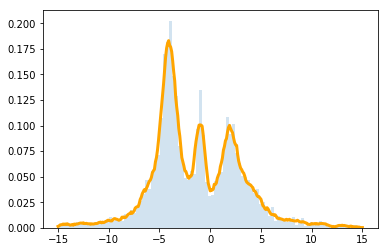

In [17]:
H = plt.hist(x, bins=100, density=True, alpha =0.2)

grid = np.arange(-15,15.01,0.1)
PDFtophat = kde_sklearn(x, grid, bandwidth = .5, kernel = 'tophat')
plt.plot(grid, PDFtophat, color="Orange", lw=3)

<IPython.core.display.Javascript object>


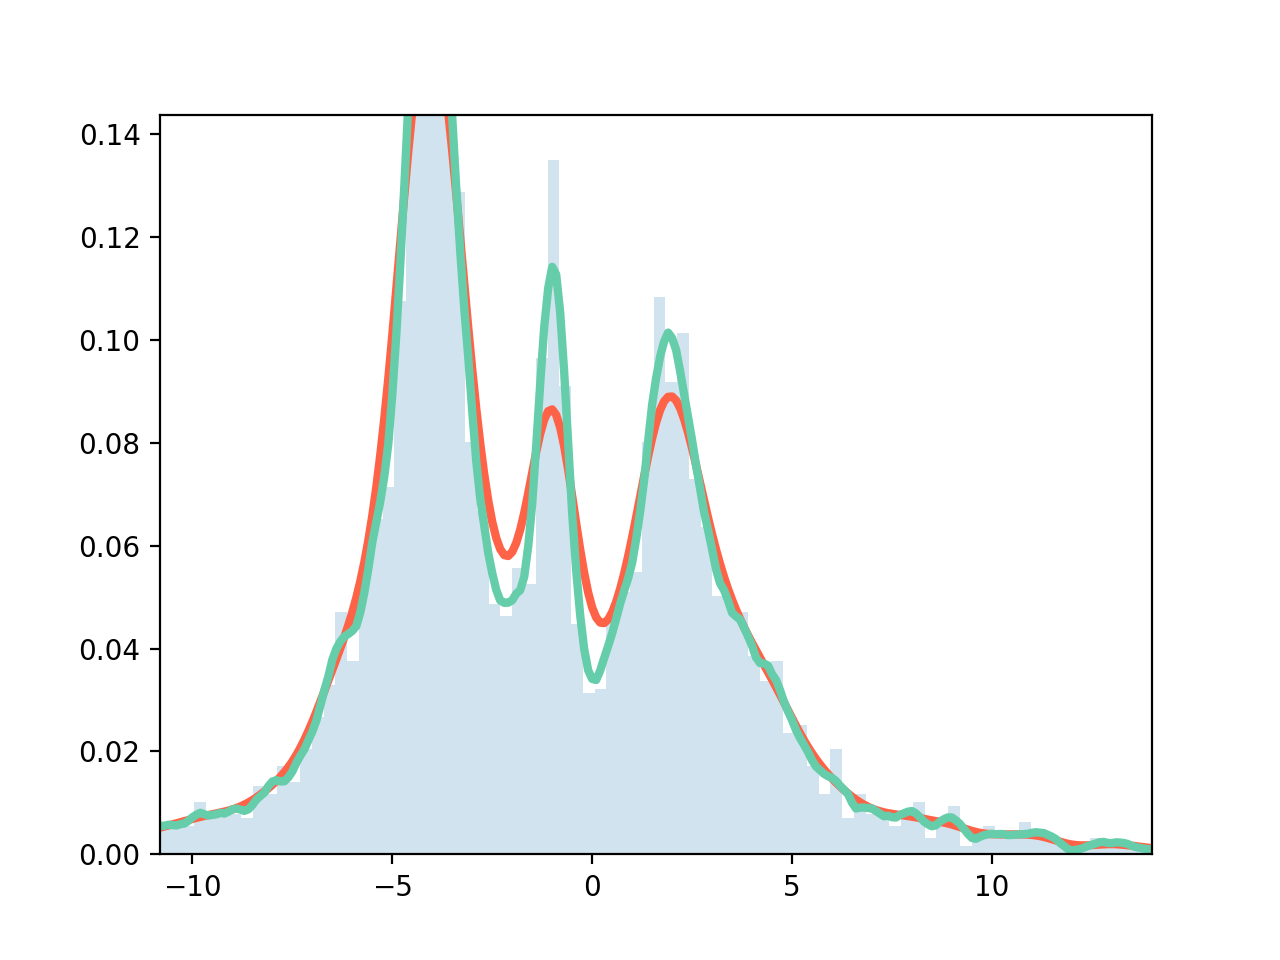

In [131]:
H = plt.hist(x, bins=100, density=True, alpha =0.2)

PDFgaussian = kde_sklearn(x, grid, bandwidth = .5, kernel = 'gaussian')
plt.plot(grid, PDFgaussian, 'Tomato', lw = 3, label = "gaussian")

PDFepanechnikov = kde_sklearn(x, grid, bandwidth = .5, kernel = 'epanechnikov')
plt.plot(grid, PDFepanechnikov, 'MediumAquamarine', lw = 3, label = "epanechnikov")


**Problem 1d**

Which parameters most affected the shape of the final distribution?

What are some possible issues with using a KDE representation of the data?

*Discuss with your partner*

**Solution 1d**

*Write your response here*

**KDEs are an improvement, but they are not perfect!**

KDEs often provide a better representation of the PDF than histograms, but they still require the user to choose the kernel and bandwidth (the bandwidth is generally more important than the choice of kernel). Frustratingly, there are no hard and fast rules for making the *optimal* choices (although there are some guidelines, see below), so one often ends up fiddling with these values until the output looks "right".

*As a reminder, if the underlying PDF is close to Gaussian, you can calculate a good estimate for the bandwith using Silverman's rule of thumb:*
$$h = 1.059 \sigma n^{-1/5}$$

*but this rule gives poor results in other cases! See Session 4 Day 0 for an extended discussion.*

## Problem 2) Histograms Episode IV: A New Hope 

How can we create representations of our data that are robust against the known issues with histograms and KDEs?

![ChessUrl](https://media.giphy.com/media/DrL54YGfFb5Bu/giphy.gif "leia")



**Introducing: Bayesian Blocks**

We want to represent our data in the most general possible way, a method that
* avoids assumptions about smoothness or shape of the signal (which might place limitations on scales and resolution)
* is nonparametric (doesn't fit some model)
* finds and characterizes local structure in our time series (in contrast to periodicities)

(continued)

* handles arbitrary sampling (i.e. doesn't require evenly spaced samples, doesn't care about sparse samples)
* is as hands-off as possible-- user interventions should be minimal or non-existent 
* is applicable to multivariate data
* can both analyze data after they are collected, and in real time 

Bayesian Blocks works by creating a super-simple representation of the data, essentially a piecewise fit that segments our time series. 

In the implementations we will use today, the model is a piecewise linear fit in time across each individual bin, or "block". 
one modeling the signal as linear in time across the block:
$$x(t) = λ(1 + a(t − t_{fid}))$$ 

where $\lambda$ is the signal strength at the fiducial time $t_{fid}$, and the coefficient $a$ determines the rate of change over the block. 

Scargle et al. (2012) point out that using a linear fit is good because it makes calculating the fit really easy, but you could potentially use something more complicated (they provide some details for using an exponential model, $x(t) = λe^{a(t−t_{fid}})$, in their Appendix C.

**The Fitness Function**

![](https://media.giphy.com/media/sLs8Ll8Qx51xm/giphy.gif "fitness")

The insight in Bayesian Blocks is that you can use a Bayesian likelihood framework to compute a "fitness function" that depends only on the number and size of the blocks. 

In every block, you are trying to maximize some goodness-of-fit measure for data in that individual block. This fit depends *only* on the data contained in its block, and is independent of all other data.

The optimal segmentation of the time series, then, is the segmentation that maximizes fitness-- the *total* goodness-of-fit over *all* the blocks (so for example, you could use the sum over all blocks of whatever your quantitative expression is for the goodness of fit in individual blocks). 
![](https://media.giphy.com/media/5YtiXID98BjAESGkn9/giphy.gif)

The entire time series is then represented by a series of segments (blocks) characterized by very few parameters:

* $N_{cp}$: the number of change-points

* $t_{k}^{cp}$: the change-point starting block k

* $X_k$: the signal amplitude in block k

for k = 1, 2, ... $N_{cp}$

When using Bayesian Blocks (particularly on time series data) we often speak of "change points" rather than segmentation, as the block edges essentially tell us the discrete times at which a signal’s statistical properties change discontinuously, though the segments themselves are constant between these points. 

**You looking at KDEs right now:**
![ChessUrl](https://media.giphy.com/media/MpmrNx3scJrPy/giphy.gif "meangirls")

In some cases (such as some of the examples below), the Bayesian Block representation may look kind of clunky. *HOWEVER*: remember that histograms and KDEs may sometimes look nicer, but can be really misleading! If you want to derive *physical insight* from these representations of your data, Bayesian Blocks can provide a means of deriving physically interesting quantities (for example, better estimates of event locations, lags, amplitudes, widths, rise and decay times, etc). 

On top of that, you can do all of the above without losing or hiding information via smoothing or other model assumptions. 

**HOW MANY BLOCKS, THO?!**

We began this lesson by bemoaning that histograms force us to choose a number of bins, and that KDEs require us to choose a bandwidth. Furthermore, one of the requirements we had for a better way forward was that the user interaction be minimal or non-existent. What to do?

Bayesian Blocks works by defining a prior distribution for the number of blocks, such that a single parameter controls the steepness of this prior (in other words, the relative probability for smaller or larger numbers of blocks. 

Once this prior is defined, the size, number, and locations of the blocks are determined solely and uniquely by the data. 

**So, what does the prior look like?**

In most cases, $N_{blocks}$ << N (you are, after all, still binning your data-- if $N_{blocks}$ was close to N, you wouldn't really be doing much). Scargle et al. (2012) adopts a geometric prior (Coram 2002), which assigns smaller probability to a large number of blocks:

$$P(N_{blocks}) = P_{0}\gamma N_{blocks}$$

for $0 ≤ N_{blocks} ≤ N$, and zero otherwise since $N_{blocks}$ cannot be negative or larger than the number of data cells. 

Substituting in the normalization constant $P_{0}$ gives

$$P(N_{blocks}) = \frac{1−\gamma}{1-\gamma^{N+1}}\gamma^{N_{blocks}}$$

<sub>Essentially, this prior says that finding k + 1 blocks is less likely than finding k blocks by the constant factor $\gamma$. Scargle (2012) also provides a nice intuitive way of thinking about $\gamma$: $\gamma$ is adjusting the amount of structure in the resulting representation.</sub>


**The Magic Part**

At this point, you may be wondering about how the algorithm is capable of finding an *optimal* number of blocks. As Scargle et al (2012) admits 
>the number of possible partitions (i.e. the number of ways N cells can be arranged in blocks) is $2^N$. This number is exponentially large, rendering an explicit exhaustive search of partition space utterly impossible for all but very small N."

![](https://media.giphy.com/media/MIY4jpusckRmU/giphy.gif "cookiebored")

In his blog post on Bayesian Blocks, Jake VdP compares the algorithm's use of *dynamic programming* to mathematical induction. For example: how could you prove that  

$$1 + 2 + \cdots + n = \frac{n(n+1)}{2}$$

is true for all positive integers $n$? An inductive proof of this formula proceeds in the following fashion:

**Base Case**: We can easily show that the formula holds for $n = 1$.

**Inductive Step**: For some value $k$, assume that $1 + 2 + \cdots + k = \frac{k(k+1)}{2}$ holds. 


Adding $(k + 1)$ to each side and rearranging the result yields 

$$1 + 2 + \cdots + k + (k + 1) = \frac{(k + 1)(k + 2)}{2}$$

Looking closely at this, we see that we have shown the following: if our formula is true for $k$, then it must be true for $k + 1$.

By 1 and 2, we can show that the formula is true for any positive integer $n$, simply by starting at $n=1$ and repeating the inductive step $n - 1$ times.

In the Bayesian Blocks algorithm, one can find the optimal binning for a single data point; so by analogy with our example above (full details are given in the Appendix of Scargle et al. 2012), if you can find the optimal binning for $k$ points, it's a short step to the optimal binning for $k + 1$ points. 

So, rather than performing an exhaustive search of all possible bins, which would scale as $2^N$, the time to find the optimal binning instead scales as $N^2$.

![](https://media.giphy.com/media/12NUbkX6p4xOO4/giphy.gif "shia")

**Playing with Blocks**

We will begin playing with (Bayesian) blocks with a simple implementation, outlined by Jake VanderPlas in this blog: https://jakevdp.github.io/blog/2012/09/12/dynamic-programming-in-python/

In [30]:
# execute this cell

def bayesian_blocks(t):
    """Bayesian Blocks Implementation

    By Jake Vanderplas.  License: BSD
    Based on algorithm outlined in http://adsabs.harvard.edu/abs/2012arXiv1207.5578S

    Parameters
    ----------
    t : ndarray, length N
        data to be histogrammed

    Returns
    -------
    bins : ndarray
        array containing the (N+1) bin edges

    Notes
    -----
    This is an incomplete implementation: it may fail for some
    datasets.  Alternate fitness functions and prior forms can
    be found in the paper listed above.
    """
    # copy and sort the array
    t = np.sort(t)
    N = t.size

    # create length-(N + 1) array of cell edges
    edges = np.concatenate([t[:1],
                            0.5 * (t[1:] + t[:-1]),
                            t[-1:]])
    block_length = t[-1] - edges

    # arrays needed for the iteration
    nn_vec = np.ones(N)
    best = np.zeros(N, dtype=float)
    last = np.zeros(N, dtype=int)

    #-----------------------------------------------------------------
    # Start with first data cell; add one cell at each iteration
    #-----------------------------------------------------------------
    for K in range(N):
        # Compute the width and count of the final bin for all possible
        # locations of the K^th changepoint
        width = block_length[:K + 1] - block_length[K + 1]
        count_vec = np.cumsum(nn_vec[:K + 1][::-1])[::-1]

        # evaluate fitness function for these possibilities
        fit_vec = count_vec * (np.log(count_vec) - np.log(width))
        fit_vec -= 4  # 4 comes from the prior on the number of changepoints
        fit_vec[1:] += best[:K]

        # find the max of the fitness: this is the K^th changepoint
        i_max = np.argmax(fit_vec)
        last[K] = i_max
        best[K] = fit_vec[i_max]
    
    #-----------------------------------------------------------------
    # Recover changepoints by iteratively peeling off the last block
    #-----------------------------------------------------------------
    change_points =  np.zeros(N, dtype=int)
    i_cp = N
    ind = N
    while True:
        i_cp -= 1
        change_points[i_cp] = ind
        if ind == 0:
            break
        ind = last[ind - 1]
    change_points = change_points[i_cp:]

    return edges[change_points]

**Problem 2a** 

Let's visualize our data again, but this time we will use Bayesian Blocks.

Plot a standard histogram (as above), but now plot the Bayesian Blocks representation of the distribution over it. 

In [28]:
# complete 
plt.hist(

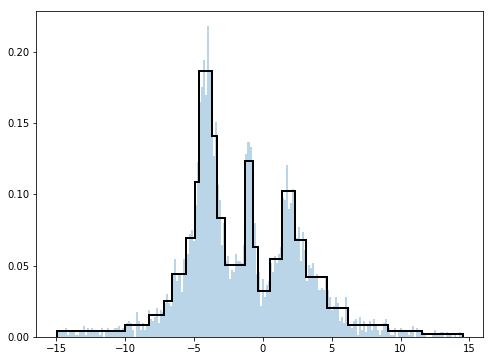

In [31]:
figure(figsize=(8, 6))

H1 = plt.hist(x, bins=200, histtype='stepfilled', alpha=0.3, density=True)

H2 = plt.hist(x, bins=bayesian_blocks(x), color='black', histtype='step', density=True, lw=2)


**Problem 2b**

How is the Bayesian Blocks representation different or similar? 

How might your choice of representation affect your scientific conclusions about your data? 

*Take a few min to discuss this with your partner*

If you are using histograms for analysis, you might infer physical meaning from the presence or absence of features in these distributions. As it happens, histograms of time-tagged event data are often used to characterize physical events in time domain astronomy, for example gamma ray bursts or stellar flares. 

## Problem 3) Bayesian Blocks in the wild

Now we'll apply Bayesian Blocks to some real astronomical data, and explore how our visualization choices may affect our scientific conclusions.

First, let's get some data!

All data from NASA missions is hosted on the Mikulski Archive for Space Telescopes (aka MAST). As an aside, the M in MAST used to stand for "Multimission", but was changed to honor Sen. Barbara Mikulski (D-MD) for her tireless support of science. 

Some MAST data (mostly the original data products) can be directly accessed using astroquery (there's an extensive guide to interacting with MAST via astroquery here: https://astroquery.readthedocs.io/en/latest/mast/mast.html). 

In addition, MAST also hosts what are called "Higher Level Science Products", or HLSPs, which are data derived by science teams in the course of doing their analyses. You can see a full list of HLSPs here: https://archive.stsci.edu/hlsp/hlsp-table

These data tend to be more heterogeneous, and so are not currently accessible through astroquery (for the most part). They will be added in the future. But never fear! You can also submit SQL queries via MAST's CasJobs interface.

Go to the MAST CasJobs http://mastweb.stsci.edu/mcasjobs/home.aspx

If I have properly remembered to tell you to create a MAST CasJobs login, you can login now (and if not, just go ahead and sign up now, it's fast)!


We will be working with the table of new planet radii by Berger et al. (2019). 
*If you like, you can check out the paper here! https://arxiv.org/pdf/1805.00231.pdf*

From the "Query" tab, select "HLSP_KG_RADII" from the Context drop-down menu. 

You can then enter your query. In this example, we are doing a simple query to get all the KG-RADII radii and fluxes from the exoplanets catalog, which you could use to reproduce the first figure, above. For short queries that can execute in less than 60 seconds, you can hit the "Quick" button and the results of your query will be displayed below, where you can export them as needed. For longer queries like this one, you can select into an output table (otherwise a default like MyDB.MyTable will be used), hit the "Submit" button, and when finished your output table will be available in the MyDB tab.

**Problem 3a**

Write a SQL query to fetch this table from MAST using CasJobs.

Your possible variables are KIC_ID, KOI_ID, Planet_Radius, Planet_Radius_err_upper, Planet_Radius_err_lower, Incident_Flux, Incident_Flux_err_upper, Incident_Flux_err_lower, AO_Binary_Flag

For very short queries you can use "Quick" for your query; this table is large enough that you should use "Submit".

*Hint: You will want to SELECT some stuff FROM a table called exoplanet_parameters*

**Solution 3a**

*Write your SQL query here*

Your query might have looked something like this:
```
select koi_id, KOI_ID, Planet_Radius, Planet_Radius_err_upper, Planet_Radius_err_lower, Incident_Flux, Incident_Flux_err_upper, Incident_Flux_err_lower, AO_Binary_Flag from exoplanet_parameters
order by planet_radius
```

Once your query has completed, you will go to the MyDB tab to see the tables you have generated (in the menu at left). From here, you can click on a table, and select Download. I would recommend downloading your file as a CSV (comma-separated value) file, as CSV are simple, and can easily read into python via a variety of methods.

**Problem 3b**

Time to read in the data! There are several ways of importing a csv into python... choose your favorite and load in the table you downloaded. 


In [38]:
# complete
df = pd.read_csv('~/Downloads/MyResult_2019611.csv')

As an aside, you could also have gone and grabbed the tables as FITS files from the HLSP webpage :) If you did that, Astropy has some nice methods for interacting with FITS files...

In [33]:
# execute this cell
t = Table.read('hlsp_kg-radii_kepler-gaia_multi_all_multi_v1_exo-cat.fits')

...including some easy ways to port them into pandas. And I love pandas. 

In [212]:
#execute this cell

df_from_fits = t.to_pandas()

**Problem 3c**

Let's look at the distribution of the small planet radii in this table, which are given in units of Earth radii. Select the planets whose radii are Neptune-sized or smaller. 

Select the planet radii for all planets smaller than Neptune in the table, and visualize the distribution of planet radii using a standard histogram. 

FWIW, pandas actually has a built-in histogram function... but it's pretty ugly

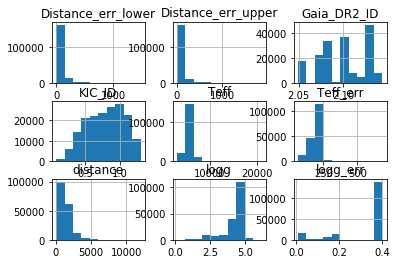

In [215]:
# execute this cell
dfh = df.hist(bins=10)

In [40]:
# complete
LilPlanets = df['planet_radius'] <= 5.

rplanet = df['planet_radius'][LilPlanets].values

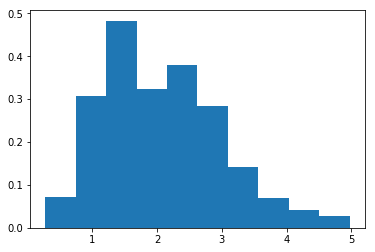

In [41]:
H = plt.hist(rplanet, density=True)

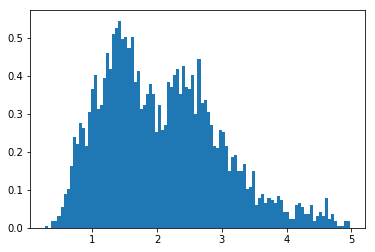

In [42]:
H = plt.hist(rplanet, bins=100,density=True)

**Problem 3d**

What features do you see in the histogram of planet radii? Which of these features are important? 

*Discuss with your partner*

**Solution 3d**

*Write your answer here*

**Problem 3e**

Now let's try visualizing these data using Bayesian Blocks. Please recreate the histogram you plotted above, and then plot the Bayesian Blocks version over it.

In [43]:
# complete

(0, 1)

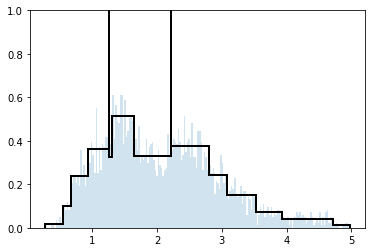

In [44]:
H1 = plt.hist(rplanet, bins=200, histtype='stepfilled', alpha=0.2, density=True)

H2 = plt.hist(rplanet, bins=bayesian_blocks(rplanet), color='black', histtype='step', density=True, lw=2)
plt.ylim(0,1)

**Problem 3f**

What features do you see in the histogram of planet radii? Which of these features are important? 

*Discuss with your partner.*

*Hint: maybe you should look at some of the comments in the implementation of Bayesian Blocks we are using*

**Solution 3f**

*Write your answer here*

OK, so in this case, the Bayesian Blocks representation of the data looks fairly different. A couple things might stand out to you:
* There are large spikes in the Bayesian Blocks representation that are not present in the standard histogram
* If we're just looking at the Bayesian Block representation, it's not totally clear whether one should believe that there are two peaks in the distribution. 

**HMMMMMmmmm....**

Wait! Jake VDP told us to watch out for this implementation. Maybe we should use something a little more official instead...

GOOD NEWS~! There is a Bayesian Blocks implementation included in astropy. Let's try that. 
http://docs.astropy.org/en/stable/api/astropy.stats.bayesian_blocks.html

In [46]:
import astropy.stats.bayesian_blocks as bb

**Important note**

There is a known issue in the astropy implementation of Bayesian Blocks; see: https://github.com/astropy/astropy/issues/8317

It is possible this issue will be fixed in a future release, but in the event this problem arises for you, you will need to edit bayesian_blocks.py to include the following ```else``` statement (see issue link above for exact edit):

 ```if self.ncp_prior is None:
            ncp_prior = self.compute_ncp_prior(N)
 else:
            ncp_prior = self.ncp_prior```

**Problem 3g**

Please repeat the previous problem, but this time use the astropy implementation of Bayesian Blocks.

In [47]:
# complete


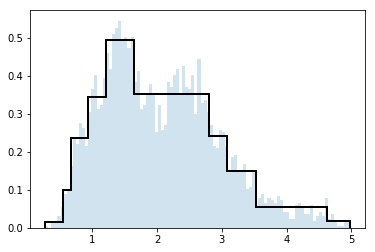

In [70]:
# plot a standard histogram in the background, with alpha transparency
H1 = plt.hist(rplanet, bins=100, histtype='stepfilled', alpha=0.2, density=True)

# plot an adaptive-width histogram on top
edges = bb(rplanet, fitness='events', p0=0.01)
H2 = plt.hist(rplanet, bins=edges, color='black', histtype='step', density=True, lw =2)


**Putting these results in context**

Both standard histograms and KDEs can be useful for quickly visualizing data, and in some cases, getting an intuition for the underlying PDF of your data.

However, keep in mind that they both involve making parameter choices that are largely not motivated in any quantitative way. These choices can create wildly misleading representations of your data. 



In particular, your choices may lead you to make a physical interpretation that may or may not be correct (in our example, bear in mind that the observed distribution of exoplanetary radii informs models of planet formation).

**Bayesian Blocks is more than just a variable-width histogram**

While KDEs often do a better job of visualizing data than standard histograms do, they also create a loss of information. Philosophically speaking, what Bayesian Blocks do is posit that the "change points", also known as the bin edges, contain information that is interesting. When you apply a KDE, you are smoothing your data by creating an approximation, and that can mean you are losing potential insights by removing information. 

While Bayesian Blocks are useful as a replacement for histograms in general, their ability to identify change points makes them especially useful for time series analysis. 

## Problem 4) Bayesian Blocks for Time Series Analysis

While Bayesian Blocks can be very useful as a simple replacement for histograms, one of its great strengths is in finding "change points" in time series data. Finding these change points can be useful for discovering interesting events in time series data you already have, *and* it can be used in real-time to detect changes that might trigger another action (for example, follow up observations for LSST). 

![](https://media.giphy.com/media/l0MYOUI5XfRk4LLWM/giphy.gif)

Let's take a look at a few examples of using Bayesian Blocks in the time series context. 

First and foremost, it's important to understand the different between various kinds of time series data. 
 
**Event data** come from photon counting instruments. In these data, the time series typically consists of photon arrival times, usually in a particular range of energies that the instrument is sensitive to. Event data are univariate, in that the time series is "how many photons at a given time", or "how many photons in a given chunk of time". 

**Point measurements** are measurements of a (typically) continuous source at a given moment in time, often with some uncertainty associated with the measurement. These data are multivariate, as your time series relates time, your measurement (e.g. flux, magnitude, etc) and its associated uncertainty to one another. 

**Problem 4a**

Let's look at some event data from BATSE, a high energy astrophysics experiment that flew on NASA's Compton Gamma-Ray Observatory. BATSE primarily studied gamma ray bursts (GRBs), capturing its detections in four energy channels: ~25-55 keV, 55-110 keV, 110-320 keV, and >320 keV.

You have been given four text files that record one of the BATSE GRB detections. Please read these data in. 


In [ ]:
# complete

In [68]:
tt1 = np.loadtxt('batse_ch1.txt')
tt2 = np.loadtxt('batse_ch2.txt')
tt3 = np.loadtxt('batse_ch3.txt')
tt4 = np.loadtxt('batse_ch4.txt')

**Problem 4b**

When you reach this point, you and your partner should pick a number between 1 and 4; your number is the channel whose data you will work with. 

Using the data for your channel, please visualize the photon events in both a standard histogram and using Bayesian Blocks. 

In [ ]:
# complete

(0.6, 1.8)

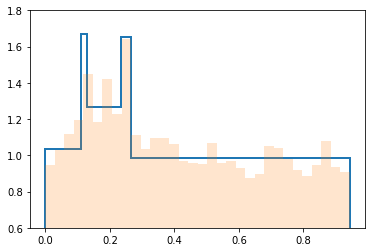

In [85]:
edges_ch1 = bb(tt1, fitness='events', ncp_prior=ncpri)
plt.hist(tt1,bins=edges_ch1, histtype='step', density=True, lw=2)
hav1 = hist(tt1,bins=32, density=True,alpha=0.2)
plt.ylim(0.6,1.8)

**Problem 4c**

Let's take a moment to reflect on the differences between these two representations of our data. 

Please discuss with your partner:
* How many bursts are present in these two representations? 
* How accurately would you be able to identify the time of the burst(s) from these representations? What about other quantities?

PS: astropy's histogram implementation has Bayesian Blocks built right in! It's not as flexible as the standalone algorithm (you can't specify your fitness function, etc) but it's very handy for quickly making good visualizations that are at least potentially more faithful to the data. 

In [132]:
from astropy.visualization import hist

<IPython.core.display.Javascript object>


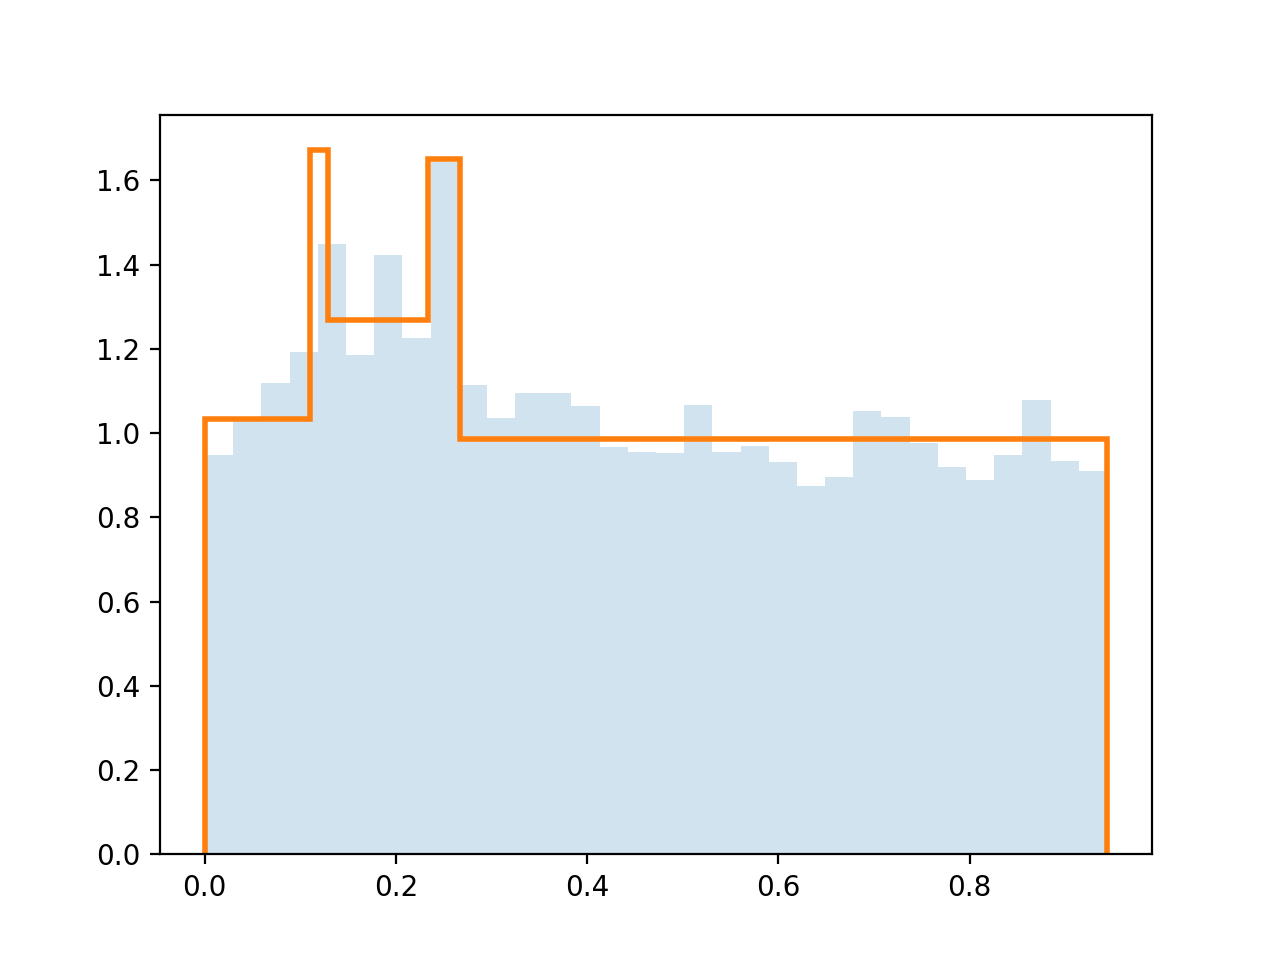

In [133]:
hav1 = hist(tt1,bins=32, density=True,alpha=0.2)
hav1bb = hist(tt1,bins='blocks',histtype="step", density=True, lw=2)


<IPython.core.display.Javascript object>


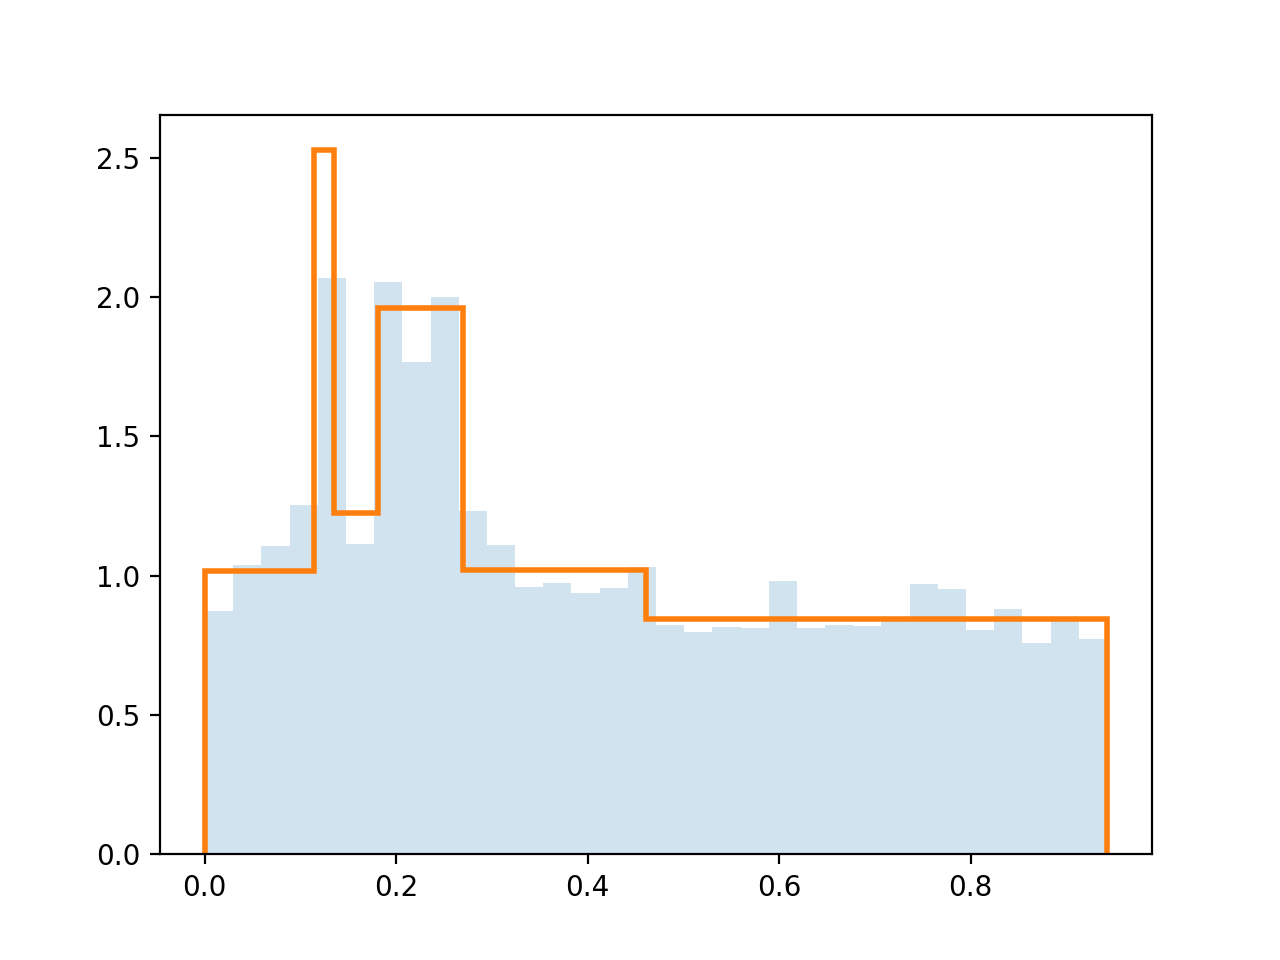

In [134]:
hav2 = hist(tt2,bins=32, density=True,alpha=0.2)
hav2bb = hist(tt2,bins='blocks',histtype="step", density=True, lw=2)


<IPython.core.display.Javascript object>


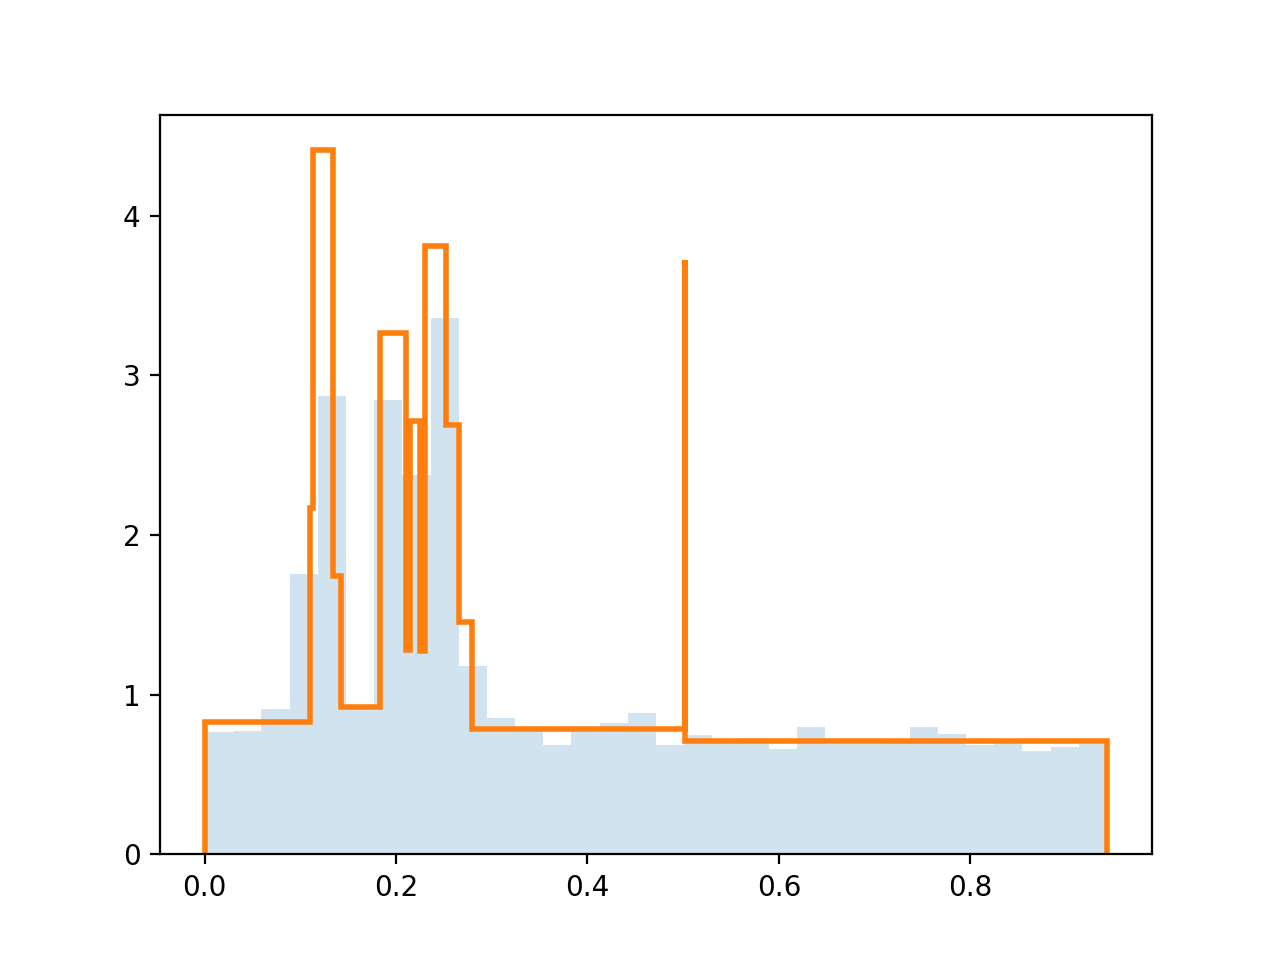

In [135]:
hav3 = hist(tt3,bins=32, density=True,alpha=0.2)
hav3bb = hist(tt3,bins='blocks',histtype="step", density=True, lw=2)


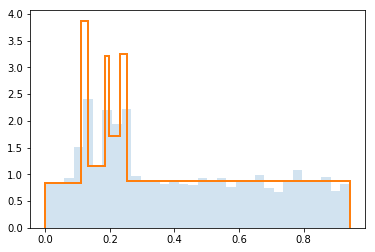

In [94]:
hav4 = hist(tt4,bins=32, density=True,alpha=0.2)
hav4bb = hist(tt4,bins='blocks',histtype="step", density=True, lw=2)

**For the groups who worked with Channel 3:**

You may have noticed very sharp features in your blocks representation of the data. Are they real?

To quote Jake VdP:

>Simply put, there are spikes because the piecewise constant likelihood model says that spikes are favored. By saying that the spikes seem unphysical, you are effectively adding a prior on the model based on your intuition of what it should look like.

To quote Jeff Scargle:

>Trust the algorithm!

## Problem 5: Finding flares 

As we have just seen, Bayesian Blocks can be very useful for finding transient events-- it worked great on our photon counts from BATSE! Let's try it on some slightly more complicated data: lightcurves from NASA's Kepler mission. Kepler's data consists primarily of point measures (rather than events)-- a Kepler lightcurve is just the change in the brightness of the star over time (with associated uncertainties).  
![](https://media.giphy.com/media/2A5feTniPI48M/giphy.gif)

**Problem 5a**

People often speak of transients (like the GRB we worked with above) and variables (like RR Lyrae or Cepheid stars) as being two completely different categories of changeable astronomical objects. However, some objects exhibit both variability *and* transient events. Magnetically active stars are one example of these objects: many of them have starspots that rotate into and out of view, creating periodic (or semi-periodic) variability, but they also have flares, magnetic reconnection events that create sudden, rapid changes in the stellar brightness. 

A challenge in identifying flares is that they often appear against a background that is itself variable. While their are many approaches to fitting both quiescent and flare variability (Gaussian processes, which you saw earlier this week, are often used for exactly this purpose!), they can be very time consuming. 

Let's read in some data, and see whether Bayesian Blocks can help us here.

In [113]:
# execute this cell
kplr_hdul = fits.open('./data/kplr009726699-2011271113734_llc.fits')

Cool, we have loaded in the FITS file. Let's look at what's in it:

In [129]:
# execute this cell
kplr_hdul.info()

Filename: ./data/kplr009726699-2011271113734_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  LIGHTCURVE    1 BinTableHDU    161   4573R x 20C   ['D', 'E', 'J', 'E', 'E', 'E', 'E', 'E', 'E', 'J', 'D', 'E', 'D', 'E', 'D', 'E', 'D', 'E', 'E', 'E']   
  2  APERTURE      1 ImageHDU        48   (11, 13)   int32   


We want the light curve, so let's check out what's in that part of the file!


In [115]:
# execute this cell
lcdata = kplr_hdul[1].data
lcdata.columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E13.6'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; uni

In [116]:
# execute this cell 

t = lcdata['TIME']
f = lcdata['PDCSAP_FLUX']
e = lcdata['PDCSAP_FLUX_ERR']
t = t[~np.isnan(f)]
e = e[~np.isnan(f)]
f = f[~np.isnan(f)]
nf = f / np.median(f)
ne = e / np.median(f)

**Problem 5b**

Use a scatter plot to visualize the Kepler lightcurve. I strongly suggest you try displaying it at different scales by zooming in (or playing with the axis limits), so that you can get a better sense of the shape of the lightcurve. 

In [124]:
# complete 


<IPython.core.display.Javascript object>


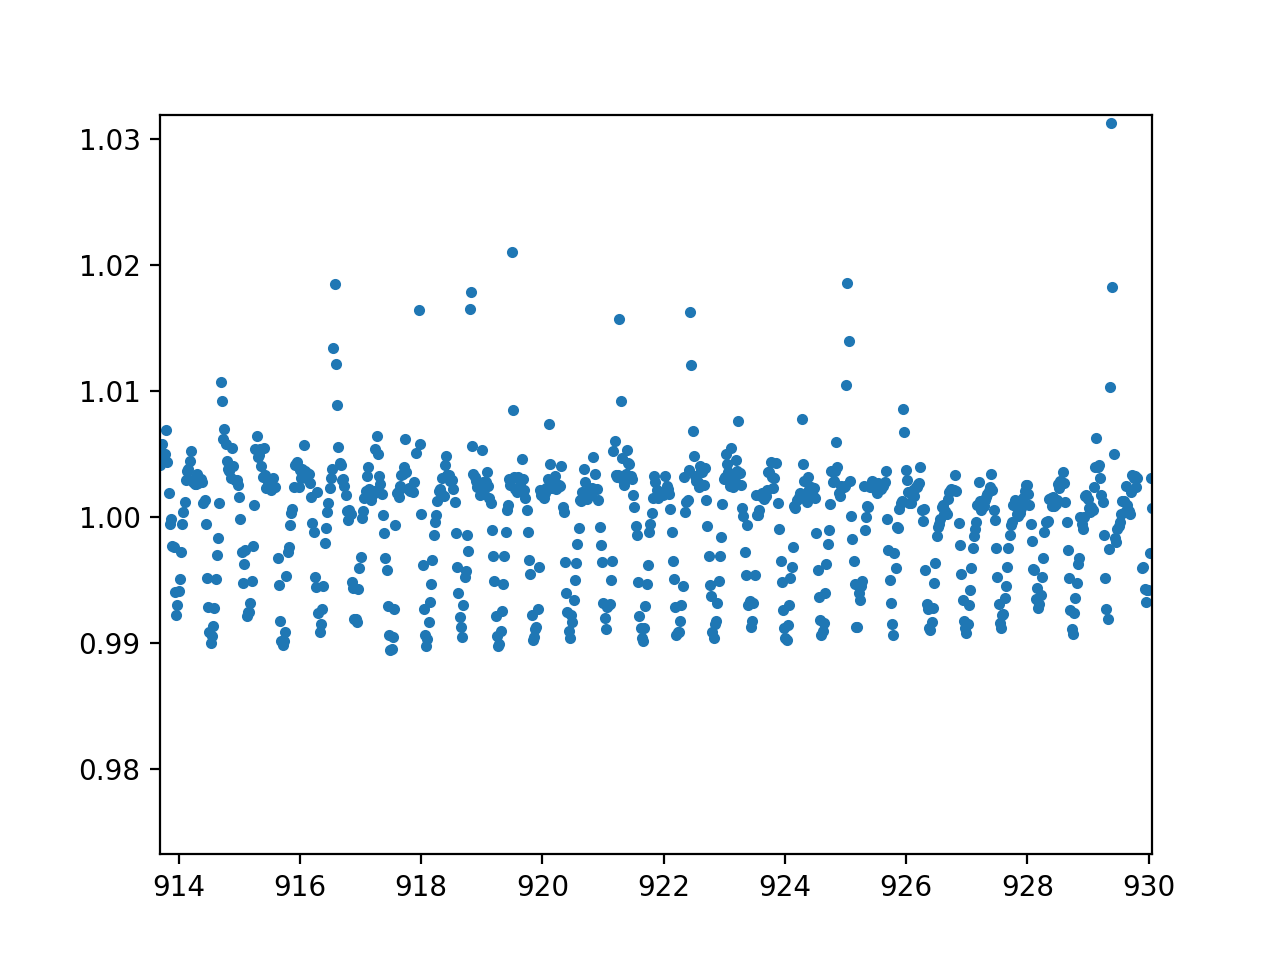

<ErrorbarContainer object of 3 artists>

In [154]:
plt.errorbar(t, nf, yerr=ne, fmt=".")

**Problem 5c**

These data consist of a variable background, with occasional bright points caused by stellar flares.

Brainstorm possible approaches to find the flare events in this data. Write down your ideas, and discuss their potential advantages, disadvantages, and any pitfalls that you think might arise. 

*Discuss with your partner*


**Solution 5c**

*Write your notes here*

There are lots of possible ways to approach this problem. In the literature, a very common traditional approach has been to fit the background variability while ignoring the outliers, then to subtract the background fit, and flag any point beyond some threshold value as belonging to a flare. More sophisticated approaches also exist, but they are often quite time consuming (and in many cases, detailed fits require a good starting estimate for the locations of flare events). 

Recall, however, that Bayesian Blocks is particularly effective at identifying change points in our data. Let's see if it can help us in this case!

**Problem 5d**

Use Bayesian Blocks to visualize the Kepler lightcurve. Note that you are now using data that consists of point measurements, rather than event data (as for the BATSE example). 

In [126]:
# complete

edges = 

In [138]:
# compute the change points using the fitness function for point measures

edges = bb(t, nf, ne, fitness='measures',p0=0.01)

In order to plot the data, you will need to compute the ordinate values in each bin-- 
traditionally (meaning Jeff Scargle does it) these are the mean value of the data in each bin.

In [139]:
vals, edgebins, binnumbers = stats.binned_statistic(t, nf, statistic='mean', bins=edges)  

The edges computed by Bayesian blocks number one less that the total number of blocks (they are change points, not exactly block boundaries). To plot correctly, you will need an additional element specifying the amplitude at the end of the last bin, so just duplicate that value and concatenate.

In [ ]:
plotvals = np.concatenate((vals, vals[len(vals)-1]), axis=None)

Now let's plot the light curve with the Bayesian Block representation over it. 

<IPython.core.display.Javascript object>


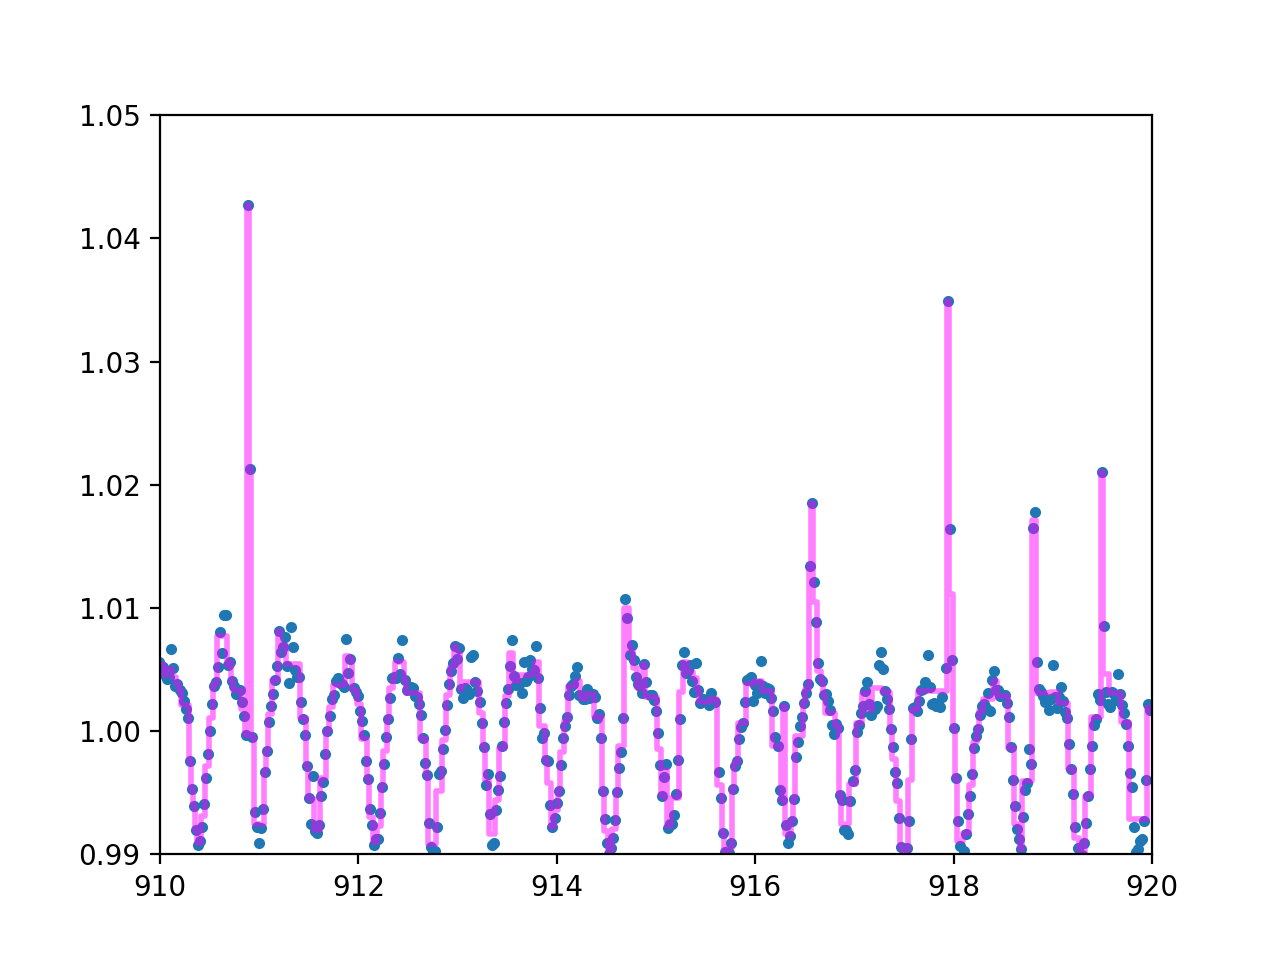

In [144]:
plt.scatter(t,nf,marker=".")
plt.xlim(910,920)
plt.ylim(0.99,1.05)
plt.step(edgebins,plotvals, where='post', color="Magenta", lw=2, alpha=0.5)


## Concluding Remarks 

As you can see, using Bayesian Blocks allowed us to represent the data, including both quiescent variability and flares, without having to smooth, clip, or otherwise alter the data. 

One potential drawback here is that the change points don't identify the flares themselves, or at least don't identify them as being different from the background variability-- the algorithm identifies change points, but does not know anything about what change points might be interesting to you in particular. 

Another potential drawback is that it is possible that the Bayesian Block representation may not catch all events, or at least may not, on its own, provide an unambiguous sign that a subtle signal of interest is in the data.

In these cases, it is sometimes instructive to use a hybrid approach, where one combines the bins determined from a traditional histogram with the Bayesian Blocks change points. Alternatively, if one has a good model for the background, one can compared the blocks representation of a background-only simulated data set with one containing both background and model signal. 

Further interesting examples (in the area of high energy physics and astrophysics) are provided by this paper:
https://arxiv.org/abs/1708.00810

## Challenge Problem

Bayesian Blocks is so great! However, there are occasions in which it doesn't perform all that well-- particularly when there are large numbers of repeated values in the data. Jan Florjanczyk, a senior data scientist at Netflix, has written up a description of the problem, and implemented a version of Bayesian Blocks that does a better job on data with repeating values. Read his blog post on "Stratfied Bayesian Blocks" and try implementing it! 
https://medium.com/@janplus/stratified-bayesian-blocks-2bd77c1e6cc7

You can either apply this to your favorite data set, or you can use it on the stellar parameters table associated with the data set we pulled from MAST earlier (recall that you previously worked with the exoplanet parameters table). You can check out the fields you can search on using MAST CasJobs, or just download a FITS file of the full table, here: https://archive.stsci.edu/prepds/kg-radii/
![](https://media.giphy.com/media/l0HlGEX1ZORa0aIvu/giphy.gif)
<sub>This GIF is of Dan Shiffman, who has a Youtube channel called Coding Train</sub>

In [146]:
dfstars = pd.read_csv('./MyTable_0_lmwalkowicz.csv')

In [147]:
def _regularize(x):
    r, s = np.unique(x, return_counts=True)
    s = (np.log(s)+1).astype(int)
    y = np.repeat(r, s)
    return y


def _normalize(x):
    r, s = np.unique(x, return_counts=True)
    s = (s - np.min(s)+1).astype(int)
    y = np.repeat(r, s)
    return y


def stratified_bayesian_blocks(x, p0=0.01, min_bin_width=0.01):
    """
    Creates smart histogram bins for mixed continuous/categorical data
    """

    # Create strata
    r, s = np.unique(x, return_counts=True)
    strata_edges = bb(s, p0=0.01)
    strata_bins = zip(strata_edges[:-1], strata_edges[1:])

    # Iterate over each strata
    data_bins = []
    for strata_bin in strata_bins:
        # Select the data pertaining only to a given strata
        sel = (strata_bin[0] <= s) & (s < strata_bin[1])
        strata_data = np.repeat(r[sel], s[sel])

        # Normalize and regularize the data within the strata
        strata_data = _regularize(_normalize(strata_data))

        # Perform Bayesian Blocks and append the bins
        edges = bb(strata_data, p0=0.01)
        data_bins.append(edges)

    # Collect the bins from all strata together
    data_bins = np.sort(np.concatenate(data_bins))

    # Clean up with the min_bin_width heuristic
    sel = (data_bins[1:]-min_bin_width) < data_bins[:-1]
    sel = np.r_[False, sel]
    data_bins = data_bins[~sel]

    return data_bins


<IPython.core.display.Javascript object>


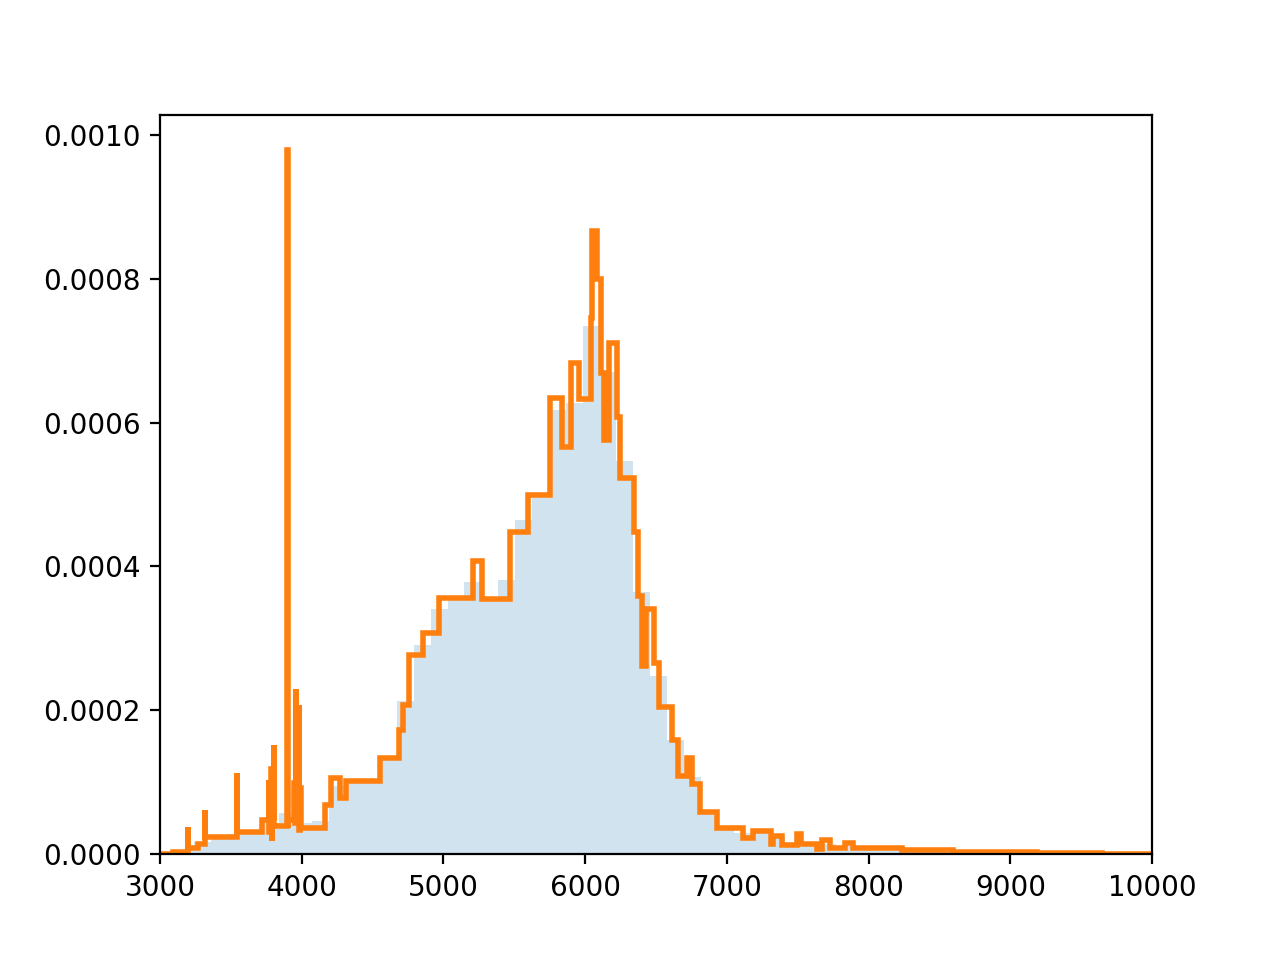

(3000, 10000)

In [152]:
# Check out the Bayesian blocks representation of the effective temperatures for stars in this sample

edges_reg=bb(dfstars['Teff'])
hstarsreg = plt.hist(dfstars['Teff'],bins=150, alpha=0.2, density=True)
hstarsbbreg = plt.hist(dfstars['Teff'], bins=edges_reg, histtype="step", lw=2, density=True)
plt.xlim(3000,10000)

This representation of our data is all fine and good-- remember, the presence of these narrow, "spike-y" bins isn't wrong (even if it doesn't conform to your mental prior of what a histogram "should" look like!). In fact, it may be telling you some useful information... typically, stellar parameters like effective temperatures and log(g) are determined via comparison with models (either by finding a best fit of the observed spectrum to some model spectrum, or a spectral template, or by looking at the stellar colors). One of the effects of determining stellar parameters this way is that sometimes certain values tend to "pile up"-- for example, you might find that you have multiple stars that are exactly 3050 K. So the Bayesian blocks representation faithfully shows that that structure exists within the data, but from a visualization standpoint perhaps doesn't look quite as nice. 

With stratified Bayesian blocks, however, we still recover the relevant structure, but narrow bins very close to one another are somewhat consolidated (without that structure being erased completely).

<IPython.core.display.Javascript object>


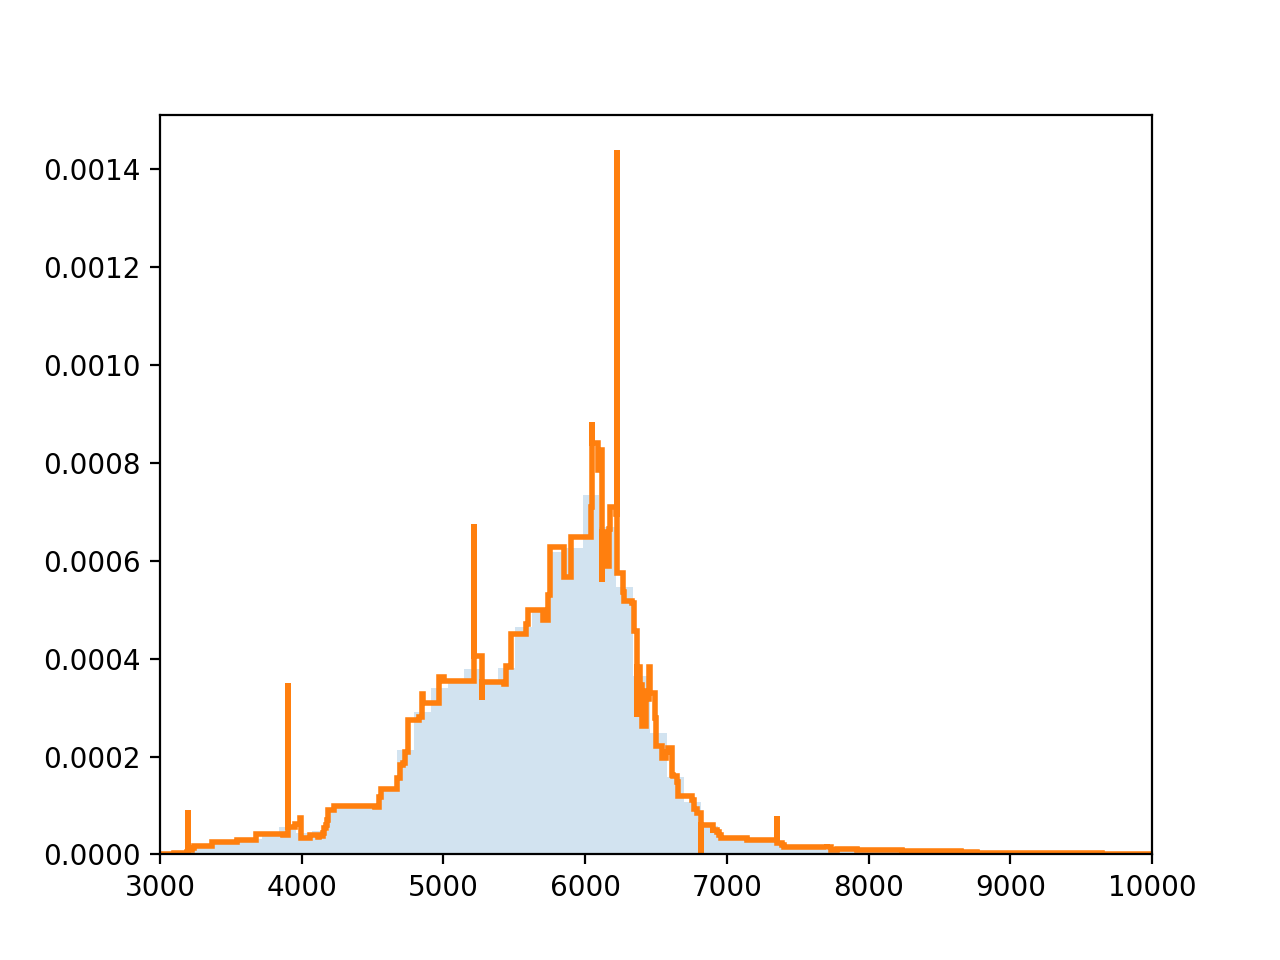

(3000, 10000)

In [151]:
# Try the stratified Bayesian blocks implementation

edges=stratified_bayesian_blocks(dfstars['Teff'])
hstars = plt.hist(dfstars['Teff'],bins=150, alpha=0.2, density=True)
hstarsbb = plt.hist(dfstars['Teff'], bins=edges, histtype="step", lw=2, density=True)
plt.xlim(3000,10000)

In [ ]:
# no code snippets provided here